Paralel convolution layers followed by maxpool (sizes 3,4 and 5) concatenated to dense layer.

Reference: Yoon Kim https://github.com/yoonkim/CNN_sentence

In [1]:
# references:
# https://www.kaggle.com/antmarakis/cnn-baseline-model
# http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
# https://github.com/yoonkim/CNN_sentence
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
seed = 12345
import random
import numpy as np
from tensorflow import set_random_seed

random.seed(seed)
np.random.seed(seed)
set_random_seed(seed)

['train.tsv', 'test.tsv', 'sampleSubmission.csv']


# Input

In [2]:
train,test,sampleSubmission = pd.read_csv('../input/train.tsv', sep = '\t'),pd.read_csv('../input/test.tsv', sep = '\t'),pd.read_csv('../input/sampleSubmission.csv')

# train,test,sampleSubmission = pd.read_csv('all/train.tsv', sep = '\t'),pd.read_csv('all/test.tsv', sep = '\t'),pd.read_csv('all/sampleSubmission.csv')
train.head(3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2


# Sentence preprocessing

In [3]:
# From Yoon Kim work:
# https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
import re
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()

phrases = [clean_str(s) for s in train['Phrase']]

In [4]:
type(train['Phrase'])
len(phrases[2].split())
phrases[2].split()

['a', 'series']

# One Hot Labels

In [5]:
from keras.utils import to_categorical
Y = to_categorical(train['Sentiment'].values)
print(Y[155:165])
print(train['Sentiment'].values[155:165])

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[2 1 0 2 0 1 2 1 1 2]


Using TensorFlow backend.


# Embedding Layer

## Text to Tokens

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=max_features)
t = Tokenizer()
t.fit_on_texts(phrases)
vocab_size = len(t.word_index) + 1
X = t.texts_to_sequences(phrases)
# print(X)
max_length = max([len(test.split()) for test in phrases ])
X = pad_sequences(X,maxlen=max_length,padding = 'post')
# print(X)
print(X.shape)

(156060, 52)


## Word Embedding + Model

- 52 words max length (52 length vector)
- embedding dim of 8 ([52,8] embedding layer)
- 3 parallel convolution layers to capture 3,4 and 5 words ([50,5],[49,5],[48,5] covolution output)
- Each convolution layer is followed by a maxpool to capture 1 feature ([1,5] output from each convolution layer)
- concatenate parallel lines
- flatten and dense layer 20% dropout rate (15 neurons to 5 outputs)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 52, 16)       244624      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 5)        245         embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

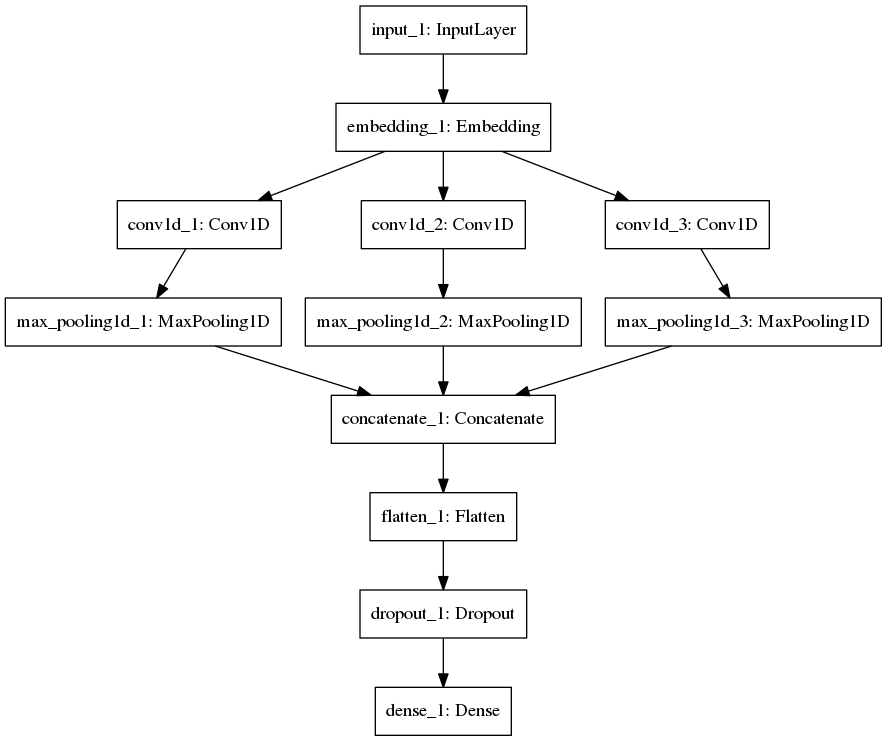

In [7]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, merge, concatenate, Input, Dropout

# ONE LAYER
def model(output_dim=8, max_length=50, y_dim=5, num_filters=5, filter_sizes = [3,5], pooling = 'max', pool_padding = 'valid', dropout = 0.2):
    # Input Layer
#     embed_input = Input(shape=(max_length,output_dim))
    embed_input = Input(shape=(max_length,))
    x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)
#     x = SpatialDropout1D(0.2)(x)
    ## concat
    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
        if pooling=='max':
            conv = MaxPooling1D(pool_size=max_length-filter_sizes[i]+1, strides=1, padding = pool_padding)(conv)
        else:
            conv = AveragePooling1D(pool_size=max_length-filter_sizes[i]+1, strides=1, padding = pool_padding)(conv)            
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
        
    x = Flatten()(merge)
    x = Dropout(dropout)(x)
#     predictions = Dense(y_dim, activation = 'sigmoid')(x)
    predictions = Dense(y_dim, activation = 'softmax')(x) # TEST
    
    model = Model(inputs=embed_input,outputs=predictions)

    model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
    print(model.summary())
    
    from keras.utils import plot_model
    plot_model(model, to_file='shared_input_layer.png')
    
    return model


model = model(output_dim=16, max_length=max_length,y_dim=5,filter_sizes = [3,4,5],pooling = 'max',dropout=0.5)
from IPython.display import Image
Image(filename='shared_input_layer.png') 


In [8]:
# ## PREVIOUS MODELS
# def model1(output_dim=8, max_length=50, y_dim=5, filter_sizes = [3]):
#     model = Sequential()
#     model.add(Embedding(vocab_size,output_dim,input_length=max_length))
#     model.add(Flatten())
#     model.add(Dense(y_dim, activation = 'sigmoid'))

#     model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
#     print(model.summary())
#     return model

# def model2(output_dim=8, max_length=50, y_dim=5, num_filters=5, filter_sizes = [3,5]):
#     model = Sequential()
#     model.add(Embedding(vocab_size,output_dim,input_length=max_length))

#     model.add(SpatialDropout1D(0.2))

#     ## GOOD
#     model.add(Conv1D(num_filters, kernel_size=filter_sizes[0], padding='valid', activation='relu'))
#     model.add(MaxPooling1D(pool_size=max_length-filter_sizes[0]+1, strides=1, padding='valid'))

#     model.add(Flatten())
#     model.add(Dense(y_dim, activation = 'sigmoid'))

#     model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
#     print(model.summary())
#     return model



# Train/Validatio Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=seed)

# Train

In [10]:
epochs = 10
batch_size = 32

model.fit(X_train,Y_train,epochs = epochs, validation_data=(X_val,Y_val), batch_size=batch_size, verbose = 1)
loss,accuracy = model.evaluate(X_val,Y_val)
print('Accuracy: %f' % (accuracy*100))

Instructions for updating:
Use tf.cast instead.
Train on 117045 samples, validate on 39015 samples
Epoch 1/10
117045/117045 [==============================] - 24s 205us/step - loss: 1.2130 - acc: 0.5364 - val_loss: 1.0488 - val_acc: 0.5867
Epoch 2/10
117045/117045 [==============================] - 23s 194us/step - loss: 1.0375 - acc: 0.5990 - val_loss: 0.9503 - val_acc: 0.6172
Epoch 3/10
117045/117045 [==============================] - 22s 190us/step - loss: 0.9577 - acc: 0.6248 - val_loss: 0.9154 - val_acc: 0.6316
Epoch 4/10
117045/117045 [==============================] - 23s 194us/step - loss: 0.9127 - acc: 0.6394 - val_loss: 0.9044 - val_acc: 0.6368
Epoch 5/10
117045/117045 [==============================] - 23s 196us/step - loss: 0.8822 - acc: 0.6502 - val_loss: 0.8995 - val_acc: 0.6388
Epoch 6/10
117045/117045 [==============================] - 23s 197us/step - loss: 0.8572 - acc: 0.6591 - val_loss: 0.8921 - val_acc: 0.6473
Epoch 7/10
117045/117045 [=============================

## Same with average pooling

In [ ]:
# epochs = 10
# batch_size = 32

# model_avg = model(output_dim=16, max_length=max_length,y_dim=5,filter_sizes = [3,4,5],pooling = 'avg',dropout=0.5)

# model_avg.fit(X_train,Y_train,epochs = epochs, validation_data=(X_val,Y_val), batch_size=batch_size, verbose = 1)
# loss,accuracy = model_avg.evaluate(X_val,Y_val)
# print('Accuracy: %f' % (accuracy*100))


Same model where max pooling layer creates catches 5 words at a time.
Previous models maxpool was on the entire text, outputing 1 feature.
This will require 'same' convolution padding so all filters outputs will be same length and concatenate will be on same size metrices.
We also have more weights so lets increase dropout.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 52, 16)       244624      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 52, 5)        245         embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 52, 5)        325         embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

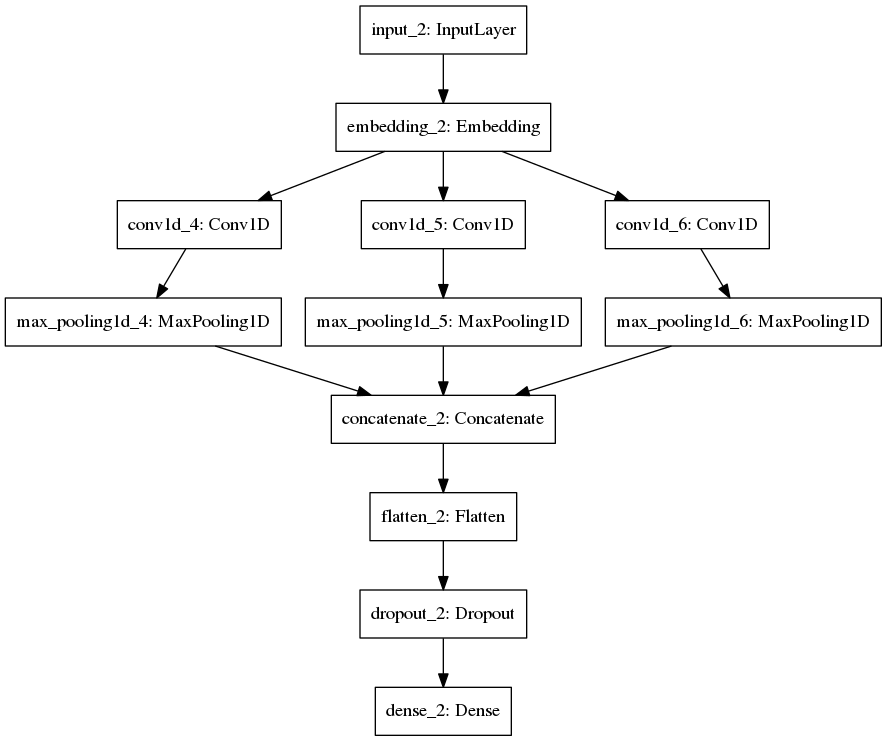

In [11]:
# ONE LAYER
def model_constant_poolsize(output_dim=8, max_length=50, y_dim=5, num_filters=5, filter_sizes = [3,5], pooling = 'max', pool_padding = 'valid', pool_size=5,dropout=0.4):
    # Input Layer
#     embed_input = Input(shape=(max_length,output_dim))
    embed_input = Input(shape=(max_length,))
    x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)
#     x = SpatialDropout1D(0.2)(x)
    ## concat
    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='same', activation='relu')(x)
        if pooling=='max':
            conv = MaxPooling1D(pool_size=pool_size, strides=1, padding = pool_padding)(conv)
        else:
            conv = AveragePooling1D(pool_size=pool_size, strides=1, padding = pool_padding)(conv)            
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
        
    x = Flatten()(merge)
    x = Dropout(dropout)(x)
#     predictions = Dense(y_dim, activation = 'sigmoid')(x)
    predictions = Dense(y_dim, activation = 'softmax')(x) # TEST
    
    model = Model(inputs=embed_input,outputs=predictions)

    model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
    print(model.summary())
    
    from keras.utils import plot_model
    plot_model(model, to_file='shared_input_layer_model_constant_poolsize.png')
    
    return model


model_constant_poolsize = model_constant_poolsize(output_dim=16, max_length=max_length,y_dim=5,filter_sizes = [3,4,5],pooling = 'max', pool_size=5,dropout = 0.5)
from IPython.display import Image
Image(filename='shared_input_layer_model_constant_poolsize.png') 


In [12]:
epochs = 10
model_constant_poolsize.fit(X_train,Y_train,epochs = epochs, validation_data=(X_val,Y_val), batch_size=batch_size, verbose = 1)
loss,accuracy = model_constant_poolsize.evaluate(X_val,Y_val)
print('Accuracy: %f' % (accuracy*100))


Train on 117045 samples, validate on 39015 samples
Epoch 1/10
117045/117045 [==============================] - 27s 234us/step - loss: 1.0713 - acc: 0.5737 - val_loss: 0.9306 - val_acc: 0.6330
Epoch 2/10
117045/117045 [==============================] - 27s 232us/step - loss: 0.8699 - acc: 0.6501 - val_loss: 0.8735 - val_acc: 0.6484
Epoch 3/10
117045/117045 [==============================] - 27s 230us/step - loss: 0.8015 - acc: 0.6756 - val_loss: 0.8674 - val_acc: 0.6513
Epoch 4/10
117045/117045 [==============================] - 27s 230us/step - loss: 0.7584 - acc: 0.6924 - val_loss: 0.8750 - val_acc: 0.6564
Epoch 5/10
117045/117045 [==============================] - 27s 230us/step - loss: 0.7253 - acc: 0.7054 - val_loss: 0.8841 - val_acc: 0.6565
Epoch 6/10
117045/117045 [==============================] - 27s 229us/step - loss: 0.6997 - acc: 0.7145 - val_loss: 0.9009 - val_acc: 0.6560
Epoch 7/10
117045/117045 [==============================] - 26s 221us/step - loss: 0.6801 - acc: 0.7223

# Create Submission

Looks like best results came from the model where maxpooling outputs more than one feature.
We'll score test data on that model

In [13]:
# pre processing
test_phrases = [clean_str(s) for s in test['Phrase']]
# text to tokens
X_test = t.texts_to_sequences(test_phrases)
X_test = pad_sequences(X_test,maxlen=max_length,padding = 'post')

In [14]:
# sampleSubmission['Sentiment'] = model.predict_classes(X_test,verbose=1)
sampleSubmission['Sentiment'] = model_constant_poolsize.predict(X_test,verbose=1).argmax(axis=-1)
sampleSubmission.to_csv('sub_cnn_constant_maxpool.csv', index=False)


sampleSubmission['Sentiment'] = model.predict(X_test,verbose=1).argmax(axis=-1)
sampleSubmission.to_csv('sub_cnn.csv', index=False)

66292/66292 [==============================] - 3s 38us/step


## Submission on model trained on full data

In [15]:
# train
model_constant_poolsize.fit(X,Y,epochs = epochs, validation_data=(X_val,Y_val), batch_size=batch_size, verbose = 1)

# submission
sampleSubmission['Sentiment'] = model_constant_poolsize.predict(X_test,verbose=1).argmax(axis=-1)
sampleSubmission.to_csv('sub_cnn_constant_maxpool_FULL.csv', index=False)

Train on 156060 samples, validate on 39015 samples
Epoch 1/10
156060/156060 [==============================] - 35s 225us/step - loss: 0.7145 - acc: 0.7162 - val_loss: 0.7689 - val_acc: 0.6983
Epoch 2/10
156060/156060 [==============================] - 35s 223us/step - loss: 0.6901 - acc: 0.7206 - val_loss: 0.7124 - val_acc: 0.7148
Epoch 3/10
156060/156060 [==============================] - 35s 226us/step - loss: 0.6731 - acc: 0.7258 - val_loss: 0.6828 - val_acc: 0.7270
Epoch 4/10
156060/156060 [==============================] - 35s 227us/step - loss: 0.6631 - acc: 0.7296 - val_loss: 0.6502 - val_acc: 0.7377
Epoch 5/10
156060/156060 [==============================] - 37s 239us/step - loss: 0.6513 - acc: 0.7324 - val_loss: 0.6312 - val_acc: 0.7427
Epoch 6/10
156060/156060 [==============================] - 37s 236us/step - loss: 0.6443 - acc: 0.7356 - val_loss: 0.6137 - val_acc: 0.7486
Epoch 7/10
156060/156060 [==============================] - 36s 231us/step - loss: 0.6379 - acc: 0.7365

Val_acc here is meaningless as we are validating on subset of train data (definitely not best practice)
TODO:
Check missclassified samples